<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_DenseNet201_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 18 08:24:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   30C    P0    28W / 165W |      9MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6299850340001285
GPU (s):
0.03152812601183541
GPU speedup over CPU: 19x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(convert_color, original=False, preprocess=False):

  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if original == True:
    print("Using the original RGB and preprocessing")
    x = tf.keras.applications.densenet.preprocess_input(x)
  elif original == False:
    x = tf.keras.layers.Rescaling(scale=1./255)(x)
    x = convert_color(x)
    print("Using the converted colors")

  if preprocess == True:
    x = tf.keras.applications.densenet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
29097984/29084464 [==============================] - 23s 1us/step
Using the original RGB and preprocessing
Epoch 1/100
360/360 [==============================] - 25s 48ms/step - loss: 0.6606 - accuracy: 0.7150 - val_loss: 0.5357 - val_accuracy: 0.7471
Epoch 2/100
360/360 [==============================] - 15s 41ms/step - loss: 0.5535 - accuracy: 0.7569 - val_loss: 0.5294 - val_accuracy: 0.7631
Epoch 3/100
360/360 [==============================] - 15s 40ms/step - loss: 0.5252 - accuracy: 0.7722 - val_loss: 0.5029 - val_accuracy: 0.7808
Epoch 4/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5096 - accuracy: 0.7759 - val_loss: 0.4794 - val_accuracy: 0.7831
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5082 - accuracy: 0.7766 - val_loss: 0.4774 - val_accuracy: 0.7980
Epoch 6/100
360/360

Epoch 54/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4016 - accuracy: 0.8291 - val_loss: 0.4138 - val_accuracy: 0.8258
Epoch 55/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3962 - accuracy: 0.8329 - val_loss: 0.4126 - val_accuracy: 0.8255
Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3969 - accuracy: 0.8306 - val_loss: 0.4094 - val_accuracy: 0.8296
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3892 - accuracy: 0.8372 - val_loss: 0.4051 - val_accuracy: 0.8279
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3979 - accuracy: 0.8305 - val_loss: 0.4099 - val_accuracy: 0.8237
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3892 - accuracy: 0.8335 - val_loss: 0.4104 - val_accuracy: 0.8237
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3939 - accuracy: 0.8331 - val_loss: 0.4203 -

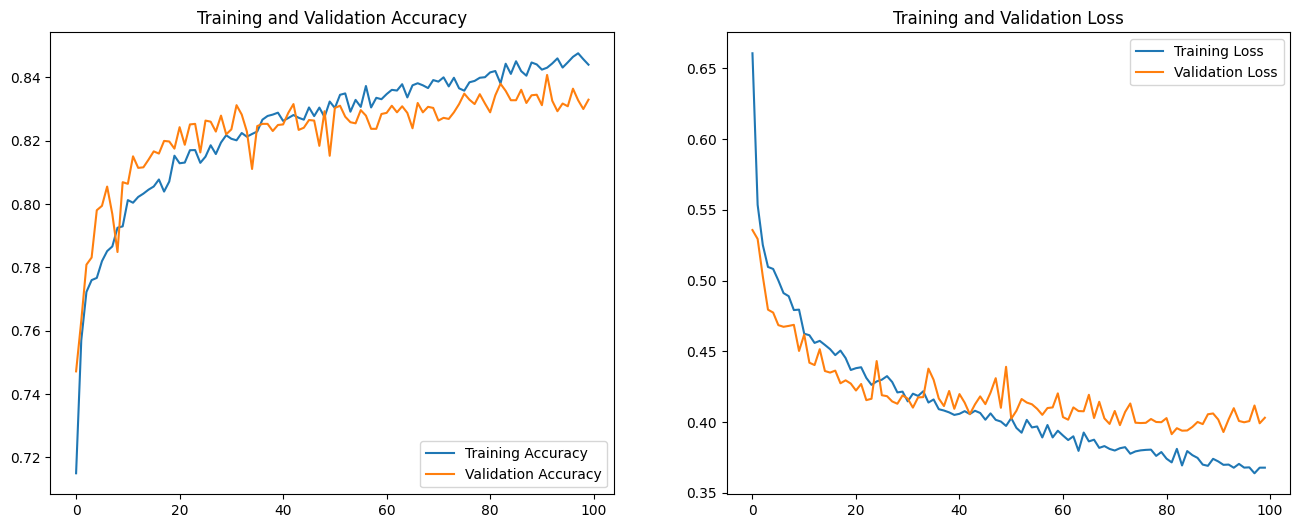

In [5]:
res_rgb = train_model(None, original=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 22s 43ms/step - loss: 0.7247 - accuracy: 0.6904 - val_loss: 0.5776 - val_accuracy: 0.7468
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6205 - accuracy: 0.7328 - val_loss: 0.5540 - val_accuracy: 0.7673
Epoch 3/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5982 - accuracy: 0.7373 - val_loss: 0.5331 - val_accuracy: 0.7669
Epoch 4/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5819 - accuracy: 0.7496 - val_loss: 0.5299 - val_accuracy: 0.7702
Epoch 5/100
360/360 [==============================] - 14s 40ms/step - loss: 0.5737 - accuracy: 0.7492 - val_loss: 0.5251 - val_accuracy: 0.7758
Epoch 6/100
360/360 [==============================] - 14s 39ms/step - loss: 0.

Epoch 56/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4550 - accuracy: 0.8059 - val_loss: 0.4650 - val_accuracy: 0.8143
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4565 - accuracy: 0.8075 - val_loss: 0.4748 - val_accuracy: 0.8084
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4553 - accuracy: 0.8101 - val_loss: 0.4580 - val_accuracy: 0.8164
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4585 - accuracy: 0.8076 - val_loss: 0.4451 - val_accuracy: 0.8183
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4525 - accuracy: 0.8102 - val_loss: 0.4538 - val_accuracy: 0.8175
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4576 - accuracy: 0.8079 - val_loss: 0.4563 - val_accuracy: 0.8154
Epoch 62/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4540 - accuracy: 0.8101 - val_loss: 0.4528 -

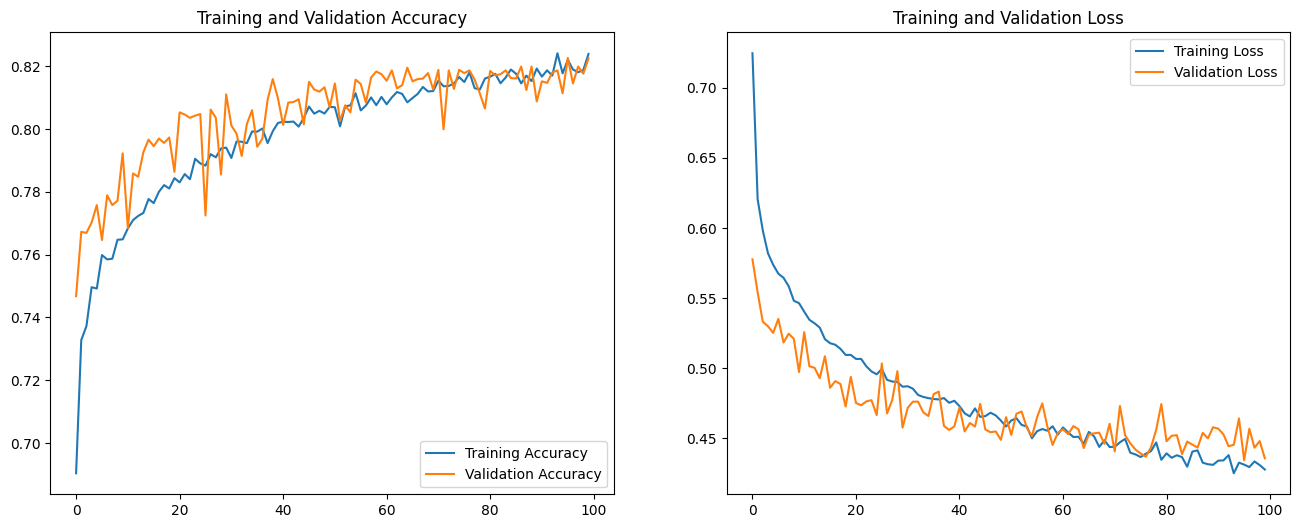

In [6]:
res_lab_pre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 22s 43ms/step - loss: 1.0161 - accuracy: 0.6003 - val_loss: 0.7430 - val_accuracy: 0.6777
Epoch 2/100
360/360 [==============================] - 14s 39ms/step - loss: 0.7861 - accuracy: 0.6599 - val_loss: 0.7315 - val_accuracy: 0.6707
Epoch 3/100
360/360 [==============================] - 14s 40ms/step - loss: 0.7510 - accuracy: 0.6768 - val_loss: 0.6866 - val_accuracy: 0.7004
Epoch 4/100
360/360 [==============================] - 14s 40ms/step - loss: 0.7285 - accuracy: 0.6864 - val_loss: 0.6996 - val_accuracy: 0.6938
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7175 - accuracy: 0.6902 - val_loss: 0.6806 - val_accuracy: 0.7115
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.6917 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5430 - accuracy: 0.7774 - val_loss: 0.5388 - val_accuracy: 0.7777
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5415 - accuracy: 0.7789 - val_loss: 0.5152 - val_accuracy: 0.7952
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5401 - accuracy: 0.7814 - val_loss: 0.5135 - val_accuracy: 0.7942
Epoch 59/100
360/360 [==============================] - 13s 38ms/step - loss: 0.5443 - accuracy: 0.7786 - val_loss: 0.5162 - val_accuracy: 0.7890
Epoch 60/100
360/360 [==============================] - 14s 39ms/step - loss: 0.5412 - accuracy: 0.7766 - val_loss: 0.5149 - val_accuracy: 0.7937
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5410 - accuracy: 0.7788 - val_loss: 0.5181 - val_accuracy: 0.7893
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.5335 - accuracy: 0.7871 - val_loss: 0.5129 -

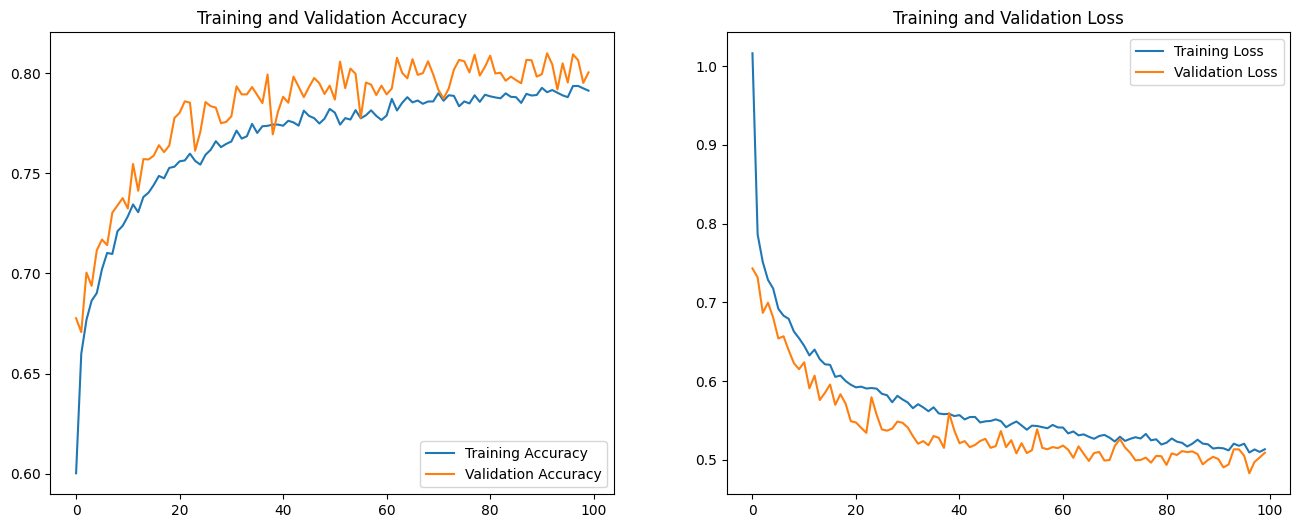

In [7]:
res_lab_nonpre = train_model(tfio.experimental.color.rgb_to_lab, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 23s 43ms/step - loss: 1.4451 - accuracy: 0.2895 - val_loss: 1.4155 - val_accuracy: 0.2746
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4271 - accuracy: 0.2927 - val_loss: 1.4094 - val_accuracy: 0.2890
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4203 - accuracy: 0.2987 - val_loss: 1.4033 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4147 - accuracy: 0.3163 - val_loss: 1.4036 - val_accuracy: 0.2860
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4038 - accuracy: 0.3319 - val_loss: 1.3792 - val_accuracy: 0.3859
Epoch 6/100
360/360 [==============================] - 14s 39ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2721 - accuracy: 0.4353 - val_loss: 1.2052 - val_accuracy: 0.4790
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2674 - accuracy: 0.4311 - val_loss: 1.2084 - val_accuracy: 0.4733
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2658 - accuracy: 0.4422 - val_loss: 1.2132 - val_accuracy: 0.4590
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2690 - accuracy: 0.4366 - val_loss: 1.2258 - val_accuracy: 0.4581
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2667 - accuracy: 0.4356 - val_loss: 1.2022 - val_accuracy: 0.4696
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2662 - accuracy: 0.4349 - val_loss: 1.1982 - val_accuracy: 0.4866
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2660 - accuracy: 0.4398 - val_loss: 1.1997 -

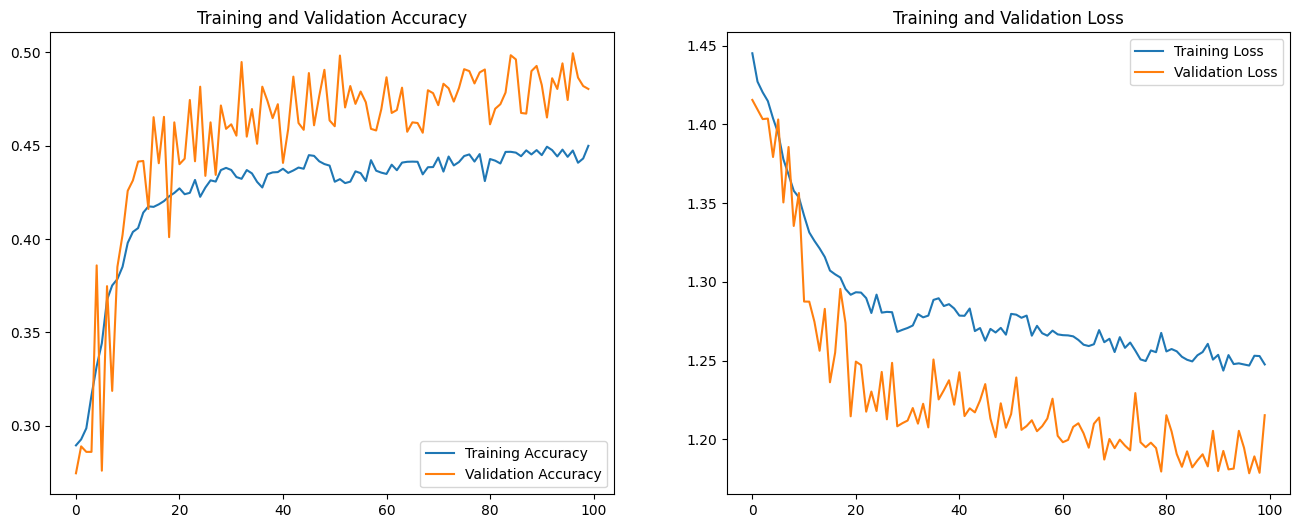

In [8]:
res_xyz_pre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 22s 43ms/step - loss: 0.6139 - accuracy: 0.7460 - val_loss: 0.4567 - val_accuracy: 0.8090
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4965 - accuracy: 0.7952 - val_loss: 0.4655 - val_accuracy: 0.8001
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4703 - accuracy: 0.8047 - val_loss: 0.4588 - val_accuracy: 0.8055
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4438 - accuracy: 0.8161 - val_loss: 0.4180 - val_accuracy: 0.8369
Epoch 5/100
360/360 [==============================] - 14s 39ms/step - loss: 0.4290 - accuracy: 0.8240 - val_loss: 0.3823 - val_accuracy: 0.8489
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4211 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3189 - accuracy: 0.8718 - val_loss: 0.3121 - val_accuracy: 0.8760
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3235 - accuracy: 0.8695 - val_loss: 0.3111 - val_accuracy: 0.8770
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3252 - accuracy: 0.8697 - val_loss: 0.3127 - val_accuracy: 0.8750
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3148 - accuracy: 0.8751 - val_loss: 0.3017 - val_accuracy: 0.8805
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3126 - accuracy: 0.8746 - val_loss: 0.3065 - val_accuracy: 0.8786
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3154 - accuracy: 0.8760 - val_loss: 0.2999 - val_accuracy: 0.8802
Epoch 62/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3196 - accuracy: 0.8728 - val_loss: 0.3068 -

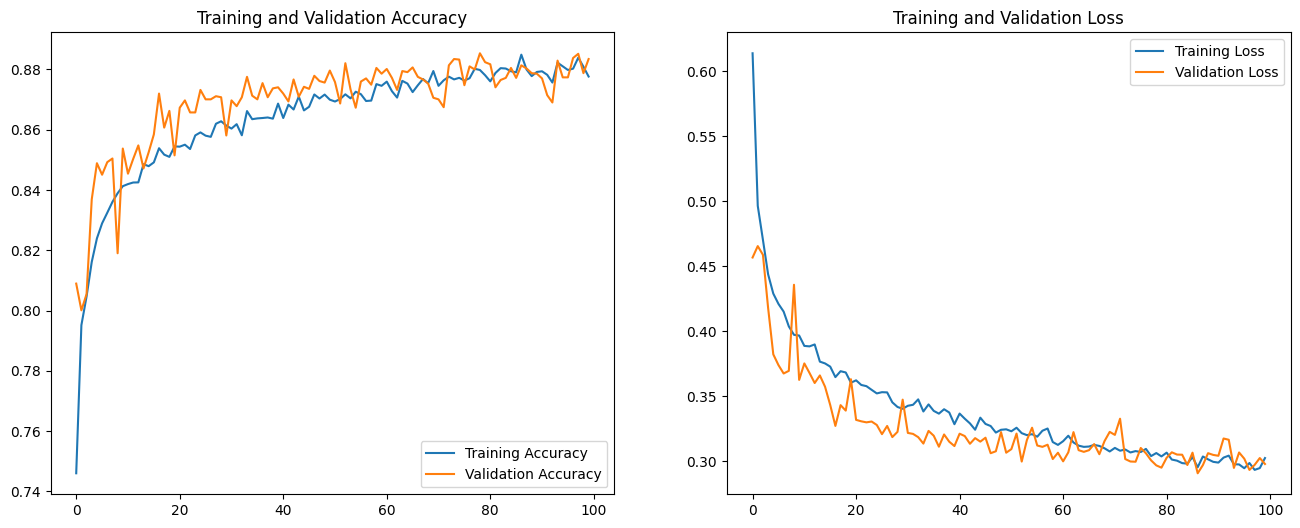

In [9]:
res_xyz_nonpre = train_model(tfio.experimental.color.rgb_to_xyz, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 22s 42ms/step - loss: 1.2328 - accuracy: 0.4426 - val_loss: 1.1299 - val_accuracy: 0.4805
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.1439 - accuracy: 0.4823 - val_loss: 1.1255 - val_accuracy: 0.4795
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 1.1124 - accuracy: 0.5009 - val_loss: 1.1010 - val_accuracy: 0.5038
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.0925 - accuracy: 0.5056 - val_loss: 1.0312 - val_accuracy: 0.5412
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.0848 - accuracy: 0.5132 - val_loss: 1.0327 - val_accuracy: 0.5427
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 36ms/step - loss: 0.9915 - accuracy: 0.5661 - val_loss: 0.9762 - val_accuracy: 0.5743
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.9920 - accuracy: 0.5679 - val_loss: 0.9481 - val_accuracy: 0.5834
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.9975 - accuracy: 0.5639 - val_loss: 1.0000 - val_accuracy: 0.5594
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.9977 - accuracy: 0.5630 - val_loss: 0.9641 - val_accuracy: 0.5738
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.9863 - accuracy: 0.5689 - val_loss: 0.9508 - val_accuracy: 0.5842
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.9907 - accuracy: 0.5713 - val_loss: 0.9526 - val_accuracy: 0.5797
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.9946 - accuracy: 0.5670 - val_loss: 0.9549 -

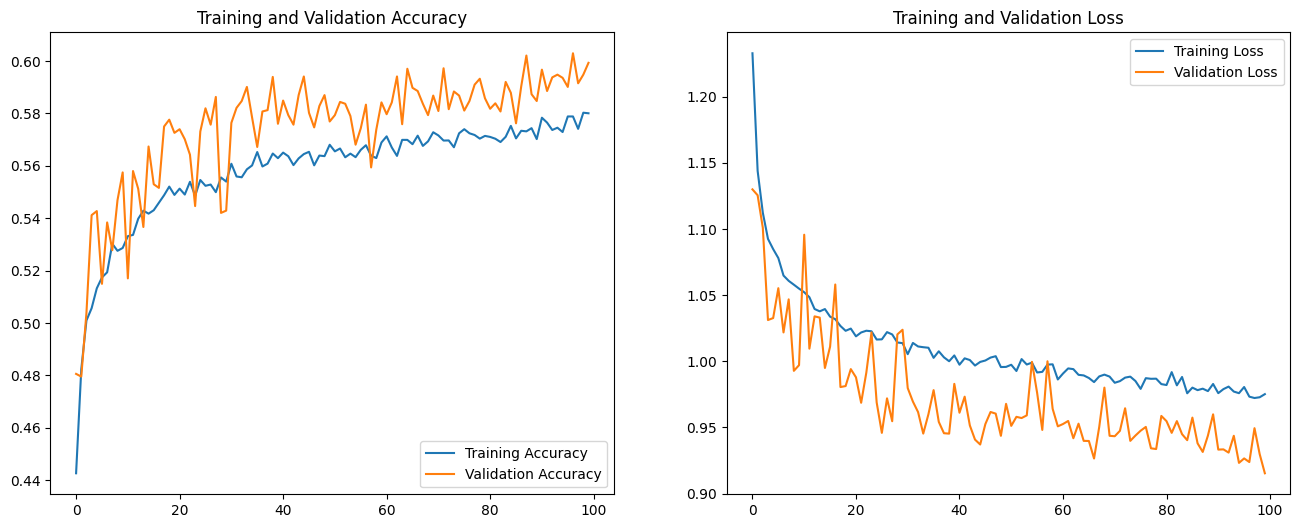

In [10]:
res_hsv_pre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 22s 42ms/step - loss: 0.9711 - accuracy: 0.5926 - val_loss: 0.7935 - val_accuracy: 0.6586
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8245 - accuracy: 0.6386 - val_loss: 0.7699 - val_accuracy: 0.6707
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8009 - accuracy: 0.6506 - val_loss: 0.7552 - val_accuracy: 0.6657
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.7864 - accuracy: 0.6535 - val_loss: 0.7571 - val_accuracy: 0.6690
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7769 - accuracy: 0.6564 - val_loss: 0.7484 - val_accuracy: 0.6744
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.7675 - accuracy: 0.6

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6549 - accuracy: 0.7107 - val_loss: 0.6964 - val_accuracy: 0.6994
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6532 - accuracy: 0.7156 - val_loss: 0.6960 - val_accuracy: 0.7006
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6629 - accuracy: 0.7031 - val_loss: 0.6983 - val_accuracy: 0.6954
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6573 - accuracy: 0.7133 - val_loss: 0.6997 - val_accuracy: 0.6971
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6600 - accuracy: 0.7135 - val_loss: 0.7006 - val_accuracy: 0.6980
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6582 - accuracy: 0.7088 - val_loss: 0.7000 - val_accuracy: 0.6962
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6521 - accuracy: 0.7142 - val_loss: 0.7126 -

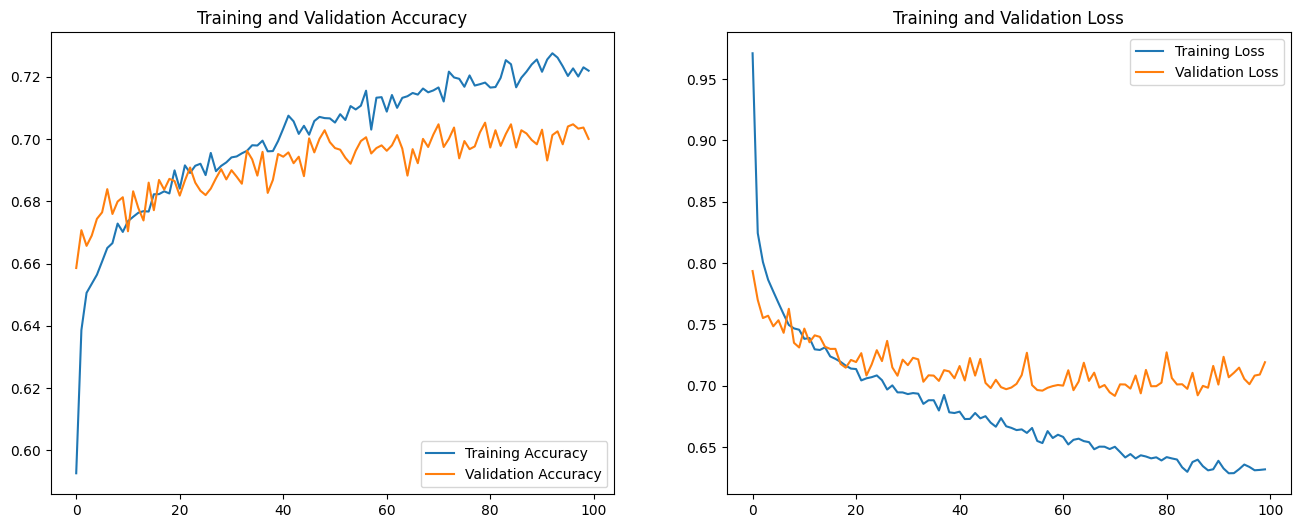

In [11]:
res_hsv_nonpre = train_model(tfio.experimental.color.rgb_to_hsv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 22s 42ms/step - loss: 1.4481 - accuracy: 0.2799 - val_loss: 1.4096 - val_accuracy: 0.3074
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4247 - accuracy: 0.2923 - val_loss: 1.4083 - val_accuracy: 0.2902
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4214 - accuracy: 0.2919 - val_loss: 1.4001 - val_accuracy: 0.2860
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4122 - accuracy: 0.2943 - val_loss: 1.3934 - val_accuracy: 0.2866
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4038 - accuracy: 0.3028 - val_loss: 1.3676 - val_accuracy: 0.3145
Epoch 6/100
360/360 [==============================] - 14s 39ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2433 - accuracy: 0.4240 - val_loss: 1.1601 - val_accuracy: 0.4863
Epoch 57/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2399 - accuracy: 0.4279 - val_loss: 1.1708 - val_accuracy: 0.4894
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2366 - accuracy: 0.4290 - val_loss: 1.1684 - val_accuracy: 0.4998
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2503 - accuracy: 0.4176 - val_loss: 1.1589 - val_accuracy: 0.4906
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2497 - accuracy: 0.4143 - val_loss: 1.1561 - val_accuracy: 0.5061
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2668 - accuracy: 0.4067 - val_loss: 1.1559 - val_accuracy: 0.4785
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2519 - accuracy: 0.4191 - val_loss: 1.1580 -

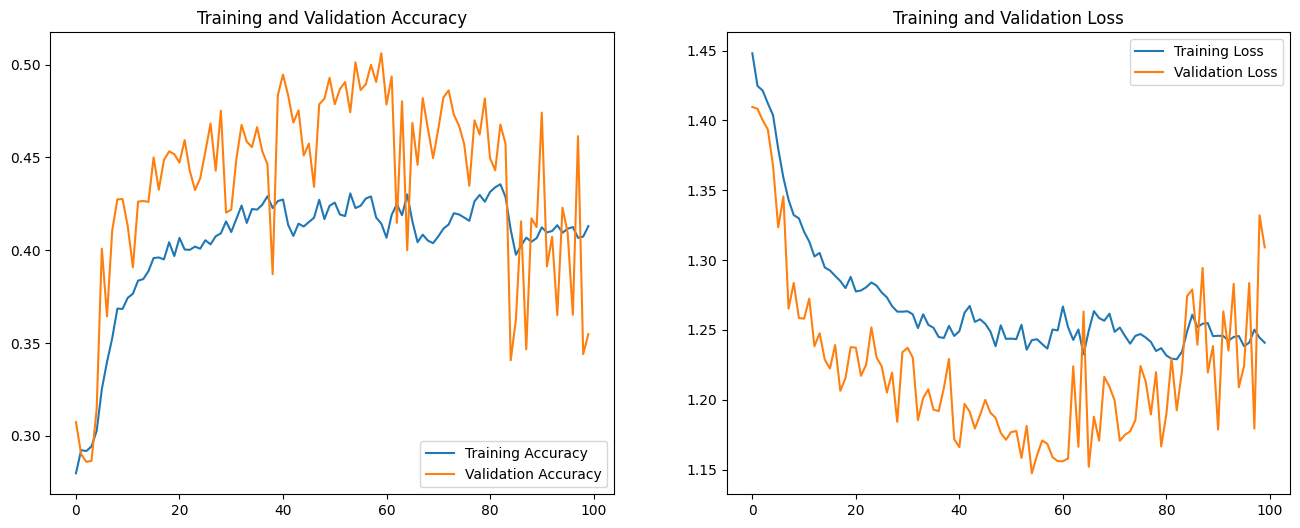

In [12]:
res_yuv_pre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 22s 42ms/step - loss: 0.6388 - accuracy: 0.7249 - val_loss: 0.4894 - val_accuracy: 0.7966
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5294 - accuracy: 0.7722 - val_loss: 0.4874 - val_accuracy: 0.7798
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5001 - accuracy: 0.7875 - val_loss: 0.4450 - val_accuracy: 0.8116
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4843 - accuracy: 0.7891 - val_loss: 0.4356 - val_accuracy: 0.8176
Epoch 5/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4715 - accuracy: 0.7984 - val_loss: 0.4341 - val_accuracy: 0.8211
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4613 - accuracy: 0.8

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3470 - accuracy: 0.8580 - val_loss: 0.3281 - val_accuracy: 0.8677
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3469 - accuracy: 0.8573 - val_loss: 0.3222 - val_accuracy: 0.8737
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 0.3427 - accuracy: 0.8600 - val_loss: 0.3503 - val_accuracy: 0.8572
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3470 - accuracy: 0.8579 - val_loss: 0.3257 - val_accuracy: 0.8694
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3457 - accuracy: 0.8602 - val_loss: 0.3151 - val_accuracy: 0.8718
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3423 - accuracy: 0.8606 - val_loss: 0.3237 - val_accuracy: 0.8640
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.3474 - accuracy: 0.8591 - val_loss: 0.3352 -

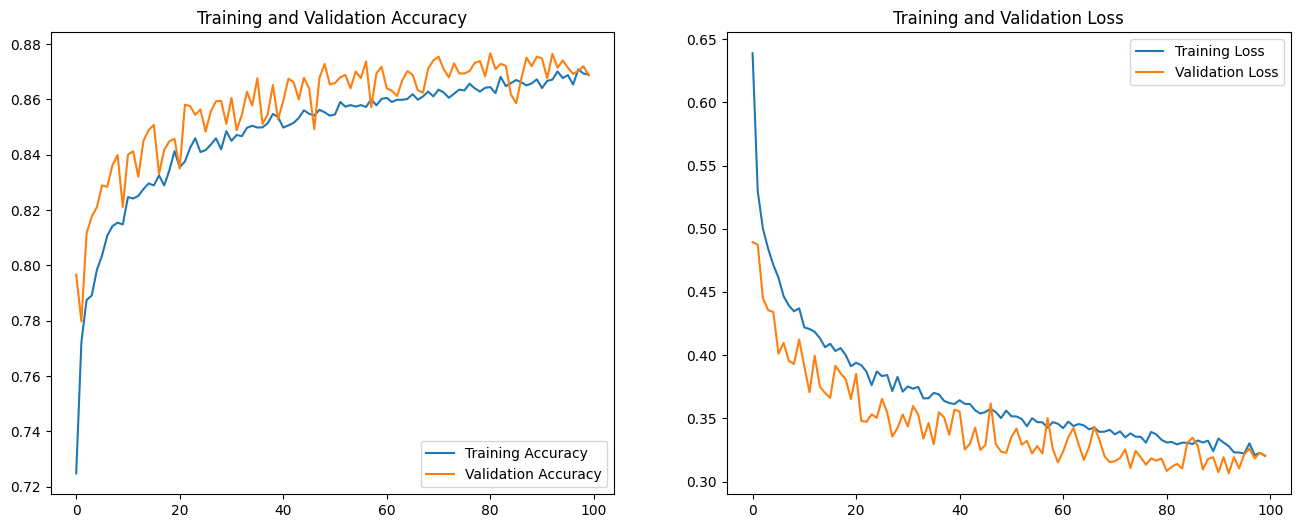

In [13]:
res_yuv_nonpre = train_model(tfio.experimental.color.rgb_to_yuv, preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Using preprocessing
Epoch 1/100
360/360 [==============================] - 23s 43ms/step - loss: 1.4481 - accuracy: 0.2902 - val_loss: 1.4072 - val_accuracy: 0.3091
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 1.4257 - accuracy: 0.2952 - val_loss: 1.4150 - val_accuracy: 0.2860
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4195 - accuracy: 0.3032 - val_loss: 1.3986 - val_accuracy: 0.2874
Epoch 4/100
360/360 [==============================] - 14s 38ms/step - loss: 1.4103 - accuracy: 0.3224 - val_loss: 1.3832 - val_accuracy: 0.4020
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 1.3904 - accuracy: 0.3488 - val_loss: 1.3372 - val_accuracy: 0.3800
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 1.

Epoch 56/100
360/360 [==============================] - 16s 44ms/step - loss: 1.2051 - accuracy: 0.4594 - val_loss: 1.1781 - val_accuracy: 0.5012
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2096 - accuracy: 0.4631 - val_loss: 1.1222 - val_accuracy: 0.5096
Epoch 58/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2071 - accuracy: 0.4609 - val_loss: 1.1743 - val_accuracy: 0.4901
Epoch 59/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2026 - accuracy: 0.4647 - val_loss: 1.1394 - val_accuracy: 0.4809
Epoch 60/100
360/360 [==============================] - 14s 38ms/step - loss: 1.1969 - accuracy: 0.4652 - val_loss: 1.1293 - val_accuracy: 0.5200
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 1.2070 - accuracy: 0.4605 - val_loss: 1.1593 - val_accuracy: 0.5108
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 1.1991 - accuracy: 0.4631 - val_loss: 1.1148 -

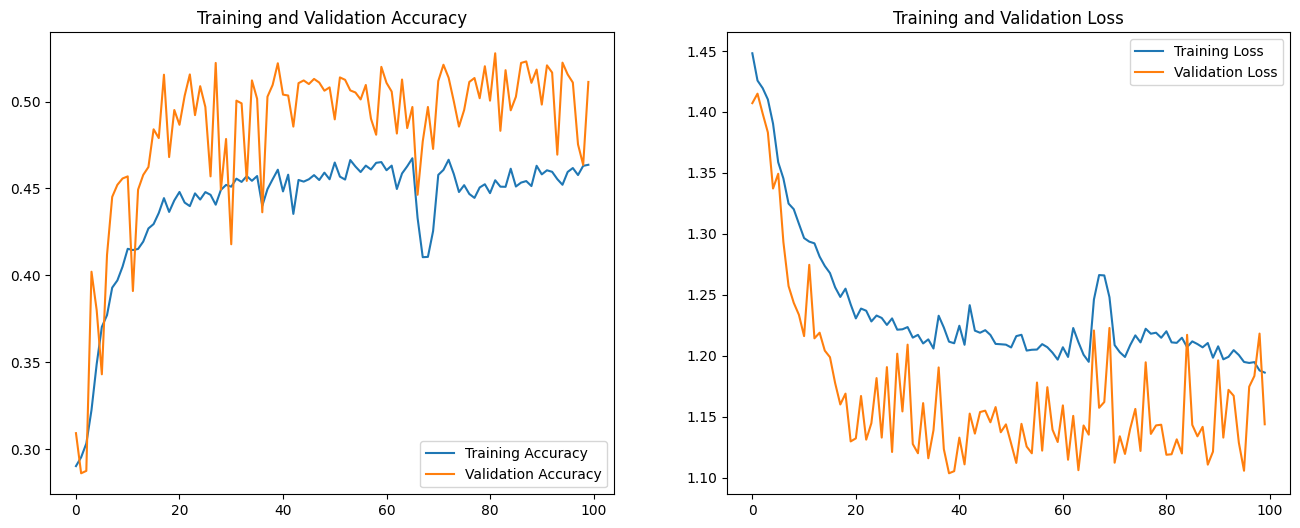

In [14]:
res_ydbdr_pre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using the converted colors
Epoch 1/100
360/360 [==============================] - 23s 42ms/step - loss: 0.7897 - accuracy: 0.6603 - val_loss: 0.6063 - val_accuracy: 0.7228
Epoch 2/100
360/360 [==============================] - 15s 43ms/step - loss: 0.6521 - accuracy: 0.7077 - val_loss: 0.5705 - val_accuracy: 0.7480
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6269 - accuracy: 0.7216 - val_loss: 0.5660 - val_accuracy: 0.7496
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6083 - accuracy: 0.7316 - val_loss: 0.5623 - val_accuracy: 0.7376
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5940 - accuracy: 0.7351 - val_loss: 0.5482 - val_accuracy: 0.7621
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5934 - accuracy: 0.7

Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4628 - accuracy: 0.8076 - val_loss: 0.4458 - val_accuracy: 0.8152
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4583 - accuracy: 0.8090 - val_loss: 0.4512 - val_accuracy: 0.8109
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4672 - accuracy: 0.8029 - val_loss: 0.4543 - val_accuracy: 0.8138
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4597 - accuracy: 0.8048 - val_loss: 0.4514 - val_accuracy: 0.8079
Epoch 60/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4621 - accuracy: 0.8054 - val_loss: 0.4558 - val_accuracy: 0.8057
Epoch 61/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4616 - accuracy: 0.8067 - val_loss: 0.4578 - val_accuracy: 0.8110
Epoch 62/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4515 - accuracy: 0.8095 - val_loss: 0.4519 -

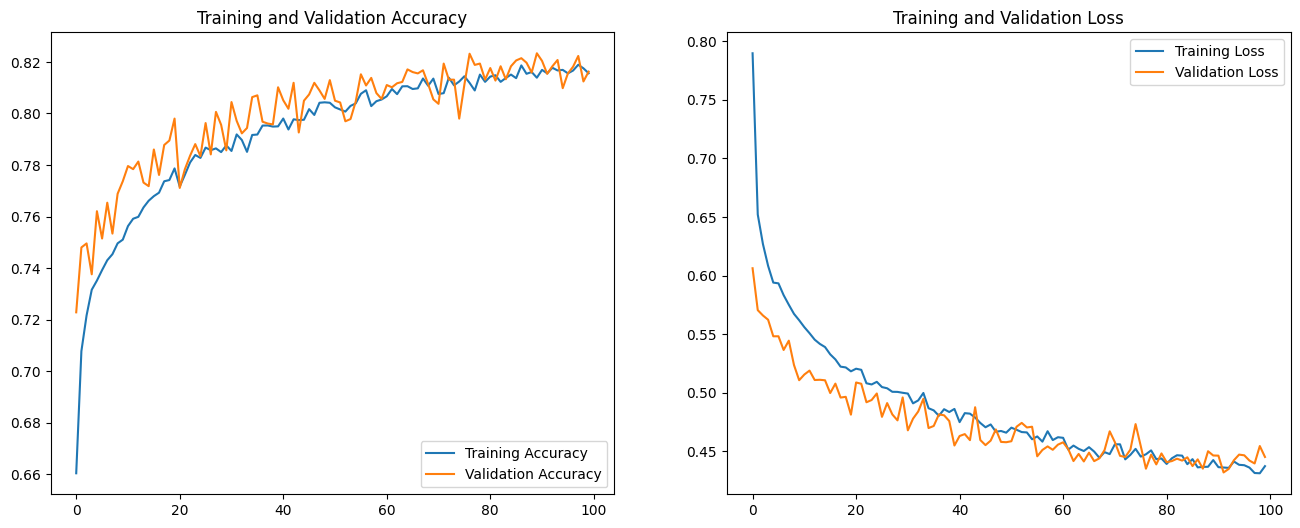

In [15]:
res_ydbdr_nonpre = train_model(tfio.experimental.color.rgb_to_ydbdr, preprocess=False)

In [17]:
# !mkdir densenet121_nontrainable
# pd.DataFrame(res_rgb).to_csv("densenet121_nontrainable/res_rgb.csv", index=False)
# pd.DataFrame(res_lab_pre).to_csv("densenet121_nontrainable/res_lab_pre.csv", index=False)
# pd.DataFrame(res_lab_nonpre).to_csv("densenet121_nontrainable/res_lab_nonpre.csv", index=False)
# pd.DataFrame(res_xyz_pre).to_csv("densenet121_nontrainable/res_xyz_pre.csv", index=False)
# pd.DataFrame(res_xyz_nonpre).to_csv("densenet121_nontrainable/res_xyz_nonpre.csv", index=False)
# pd.DataFrame(res_hsv_pre).to_csv("densenet121_nontrainable/res_hsv_pre.csv", index=False)
# pd.DataFrame(res_hsv_nonpre).to_csv("densenet121_nontrainable/res_hsv_nonpre.csv", index=False)
# pd.DataFrame(res_yuv_pre).to_csv("densenet121_nontrainable/res_yuv_pre.csv", index=False)
# pd.DataFrame(res_yuv_nonpre).to_csv("densenet121_nontrainable/res_yuv_nonpre.csv", index=False)
# pd.DataFrame(res_ydbdr_pre).to_csv("densenet121_nontrainable/res_ydbdr_pre.csv", index=False)
# pd.DataFrame(res_ydbdr_nonpre).to_csv("densenet121_nontrainable/res_ydbdr_nonpre.csv", index=False)